In [47]:
# Importar las bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# Leer el archivo CSV
csv = '2025_02.csv'
df = pd.read_csv(csv)

In [3]:
# Limpiar el encoding de columnas (si es necesario)
def limpiar_columnas(df):
    df.columns = df.columns.str.strip()  # Eliminar espacios en blanco de los nombres de columna
    return df

# Aplicar la función de limpieza de columnas
df = limpiar_columnas(df)

In [4]:
# Convertir las fechas y horas a tipos de datos datetime
df['Fecha_Retiro'] = pd.to_datetime(df['Fecha_Retiro'], format='%d/%m/%Y')
df['Hora_Retiro'] = pd.to_datetime(df['Hora_Retiro'], format='%H:%M:%S').dt.time
df['Fecha_Arribo'] = pd.to_datetime(df['Fecha_Arribo'], format='%d/%m/%Y')
df['Hora_Arribo'] = pd.to_datetime(df['Hora_Arribo'], format='%H:%M:%S').dt.time

In [5]:
# Función para limpiar la columna de estaciones
def limpiar_estacion(estacion):
    # Si hay un guion, tomamos el primer número
    if '-' in str(estacion):
        return int(estacion.split('-')[0])  # Tomamos el primer número como entero
    else:
        return int(estacion)  # Convertir el valor a entero

# Aplicar la función de limpieza a las columnas de estaciones
df['Ciclo_Estacion_Retiro'] = df['Ciclo_Estacion_Retiro'].apply(limpiar_estacion)
df['Ciclo_EstacionArribo'] = df['Ciclo_EstacionArribo'].apply(limpiar_estacion)

In [6]:
# Añadir características relevantes
df['Hora_Retiro'] = pd.to_datetime(df['Hora_Retiro'].astype(str)).dt.hour
df['Hora_Arribo'] = pd.to_datetime(df['Hora_Arribo'].astype(str)).dt.hour
df['Dia_Semana_Retiro'] = df['Fecha_Retiro'].dt.day_name()

/var/folders/fw/6l5tprsj7yl017s8ym1yb5ch0000gn/T/ipykernel_16628/3394630144.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hora_Retiro'] = pd.to_datetime(df['Hora_Retiro'].astype(str)).dt.hour
/var/folders/fw/6l5tprsj7yl017s8ym1yb5ch0000gn/T/ipykernel_16628/3394630144.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hora_Arribo'] = pd.to_datetime(df['Hora_Arribo'].astype(str)).dt.hour


In [7]:
# Contar bicicletas recogidas y dejadas por estación y hora
demand_retiro = df.groupby(['Ciclo_Estacion_Retiro', 'Hora_Retiro']).size().reset_index(name='Bicis_Retiro')
demand_arribo = df.groupby(['Ciclo_EstacionArribo', 'Hora_Arribo']).size().reset_index(name='Bicis_Arribo')

In [8]:
# Merge de datos para modelo
data = pd.merge(demand_retiro, demand_arribo, left_on=['Ciclo_Estacion_Retiro', 'Hora_Retiro'], right_on=['Ciclo_EstacionArribo', 'Hora_Arribo'], how='outer')
data = data.fillna(0)  # Reemplazar NaN con 0


In [9]:
# Definir variables dependientes e independientes
X = data[['Ciclo_Estacion_Retiro', 'Hora_Retiro']]
y_retiro = data['Bicis_Retiro']
y_arribo = data['Bicis_Arribo']

In [10]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train_retiro, y_test_retiro = train_test_split(X, y_retiro, test_size=0.2, random_state=42)
X_train, X_test, y_train_arribo, y_test_arribo = train_test_split(X, y_arribo, test_size=0.2, random_state=42)

In [11]:
# Modelar utilizando RandomForestRegressor
model_retiro = RandomForestRegressor(n_estimators=100, random_state=42)
model_retiro.fit(X_train, y_train_retiro)

model_arribo = RandomForestRegressor(n_estimators=100, random_state=42)
model_arribo.fit(X_train, y_train_arribo)

RandomForestRegressor(random_state=42)

In [12]:
# Predicciones
y_pred_retiro = model_retiro.predict(X_test)
y_pred_arribo = model_arribo.predict(X_test)


In [13]:
# Métricas de evaluación
def model_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

In [43]:
# Evaluate the model for arrival stations
mae_retiro, mse_retiro, r2_retiro = model_metrics(y_test_retiro, y_pred_retiro)
print(f'Arrival Stations - MAE: {mae_retiro:.2f}, R²: {r2_retiro:.2f}')

Arrival Stations - MAE: 33.36, R²: 0.77


# Analysis of Pickup Stations Model
The evaluation metrics for the arrival station model are as follows:

**Mean Absolute Error (MAE): 33.36**
This value indicates that, on average, the model's predictions for the number of bicycles at pickup stations are off by approximately 33 bicycles. This level of error is relatively small, suggesting that the model produces predictions that are generally close to the actual values.

**R² Value: 0.77 (77%)**
The R² value of 0.77 implies that about 77% of the variability in the number of bicycles at pickup stations can be explained by the features used in the model. Since the target was to achieve at least 75% accuracy, this result meets and successfully complains the objective. This indicates a solid fit and demonstrates that the model effectively captures the underlying trends and patterns in the pickup data

In [42]:
# Evaluate the model for arrival stations
mae_arribo, mse_arribo, r2_arribo = model_metrics(y_test_arribo, y_pred_arribo)
print(f'Arrival Stations - MAE: {mae_arribo:.2f}, R²: {r2_arribo:.2f}')

Arrival Stations - MAE: 33.54, R²: 0.83


# Analysis of Arrival Stations Model
The evaluation metrics for the arrival station model are as follows:

**Mean Absolute Error (MAE): 33.54**
This value indicates that, on average, the model's predictions for the number of bicycles at arrival stations are off by approximately 33 bicycles. This level of error is relatively small, suggesting that the model produces predictions that are generally close to the actual values.

**R² Value: 0.83 (83%)**
The R² value of 0.83 implies that about 83% of the variability in the number of bicycles arriving can be explained by the features used in the model. Since the target was to achieve at least 75% accuracy, this result meets and successfully complains the objective. This indicates a solid fit and demonstrates that the model effectively captures the underlying trends and patterns in the arrival stations data.

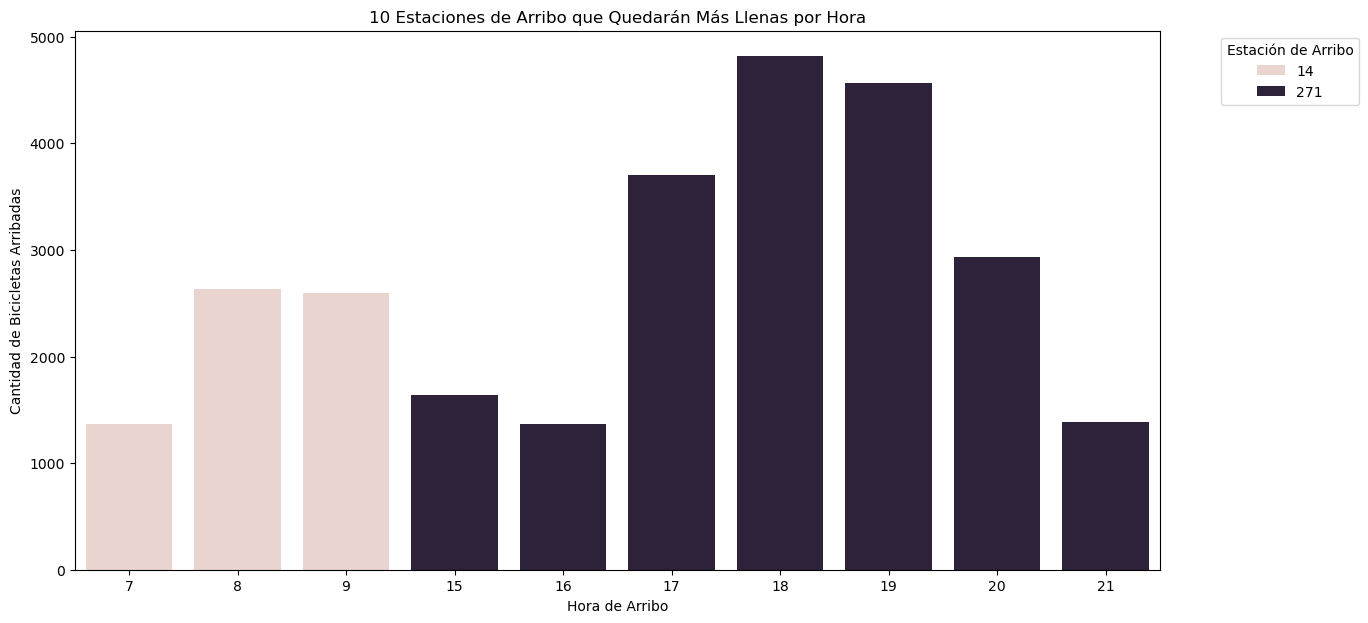

In [16]:
top_arribo_stations = demand_arribo.sort_values('Bicis_Arribo', ascending=False).head(10)

plt.figure(figsize=(14, 7))
sns.barplot(x='Hora_Arribo', y='Bicis_Arribo', hue='Ciclo_EstacionArribo', data=top_arribo_stations)
plt.title('10 Estaciones de Arribo que Quedarán Más Llenas por Hora')
plt.xlabel('Hora de Arribo')
plt.ylabel('Cantidad de Bicicletas Arribadas')
plt.legend(title='Estación de Arribo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

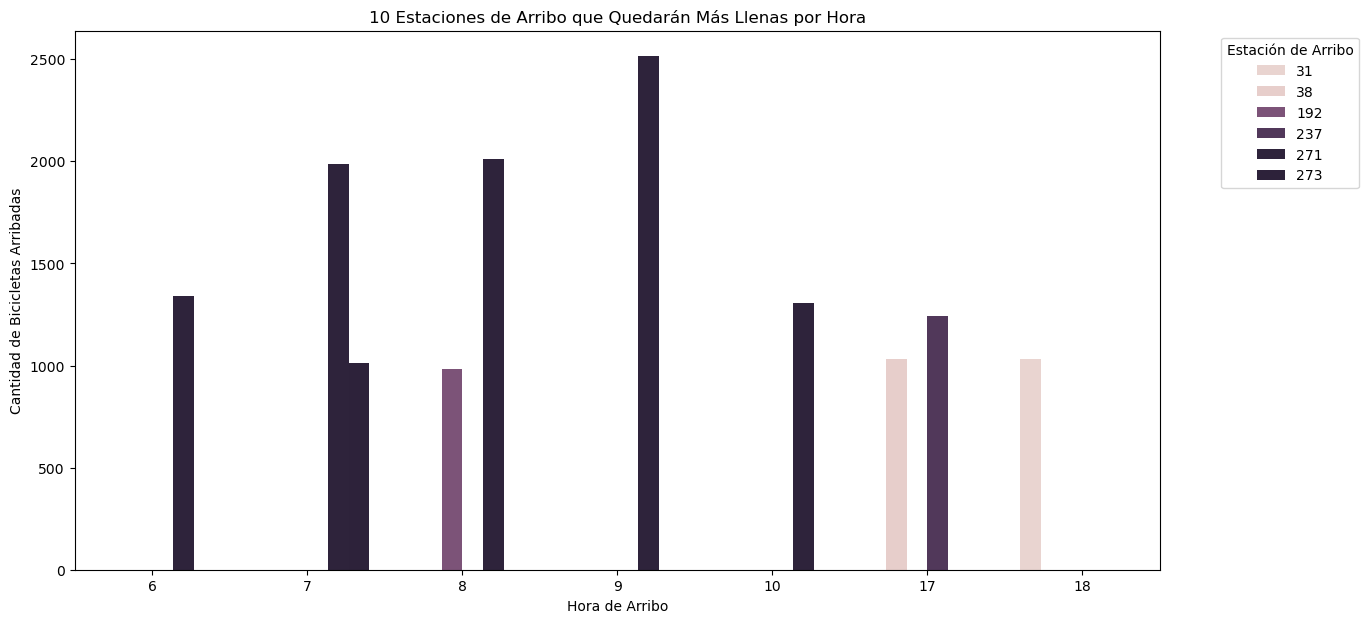

In [20]:
top_retiro_stations = demand_retiro.sort_values('Bicis_Retiro', ascending=False).head(10)

plt.figure(figsize=(14, 7))
sns.barplot(x='Hora_Retiro', y='Bicis_Retiro', hue='Ciclo_Estacion_Retiro', data=top_retiro_stations)
plt.title('10 Estaciones de Arribo que Quedarán Más Llenas por Hora')
plt.xlabel('Hora de Arribo')
plt.ylabel('Cantidad de Bicicletas Arribadas')
plt.legend(title='Estación de Arribo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [21]:
# Leer el archivo CSV con los nombres de las estaciones
estaciones_csv = 'ecobici_edited.csv'
estaciones_df = pd.read_csv(estaciones_csv)

# Limpiar el encoding de columnas en el DataFrame de estaciones
estaciones_df = limpiar_columnas(estaciones_df)

# Aplicar la función de limpieza a la columna num_cicloe
estaciones_df['num_cicloe'] = estaciones_df['num_cicloe'].apply(limpiar_estacion)

# Unir el DataFrame original con el DataFrame de estaciones usando las estaciones de retiro
df = df.merge(estaciones_df[['num_cicloe', 'nombre_estacion']], left_on='Ciclo_Estacion_Retiro', right_on='num_cicloe', how='left')
df.rename(columns={'nombre_estacion': 'Station_Name_Retiro'}, inplace=True)

# Unir el DataFrame original con el DataFrame de estaciones usando las estaciones de arribo
df = df.merge(estaciones_df[['num_cicloe', 'nombre_estacion']], left_on='Ciclo_EstacionArribo', right_on='num_cicloe', how='left')
df.rename(columns={'nombre_estacion': 'Station_Name_Arribo'}, inplace=True)

/var/folders/fw/6l5tprsj7yl017s8ym1yb5ch0000gn/T/ipykernel_16628/2975082490.py:12: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  sns.barplot(x='Hora_Retiro', y='Bicis_Retiro', hue='Station_Name_Retiro', data=top_retiro_stations, palette=palette)


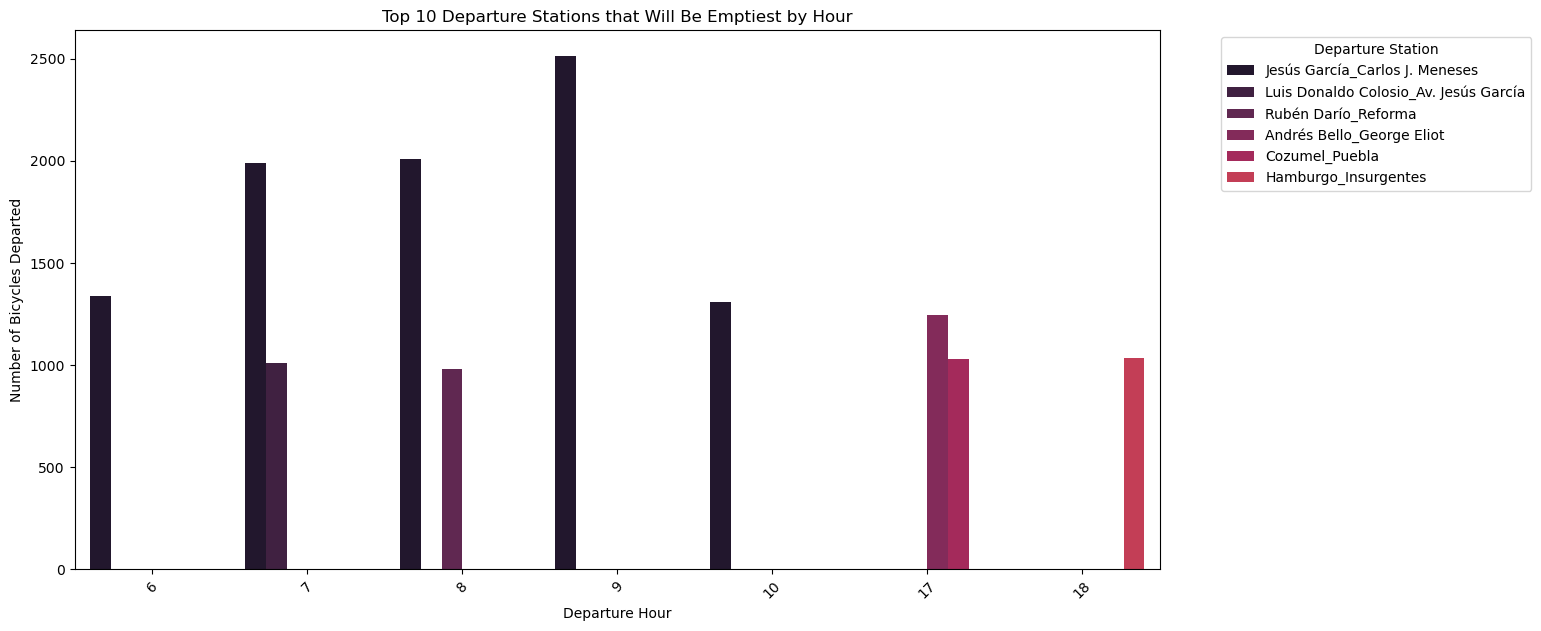

In [45]:
# Definir una paleta de colores
palette = sns.color_palette("rocket", 10)  # Cambia "husl" a otra opción si deseas una paleta diferente

# Gráficas para estaciones que quedarán más vacías por hora
top_retiro_stations = demand_retiro.sort_values('Bicis_Retiro', ascending=False).head(10)

# Unir con los nombres de estaciones para las estaciones de retiro
top_retiro_stations = top_retiro_stations.merge(estaciones_df[['num_cicloe', 'nombre_estacion']], left_on='Ciclo_Estacion_Retiro', right_on='num_cicloe', how='left')
top_retiro_stations['Station_Name_Retiro'] = top_retiro_stations['nombre_estacion']

plt.figure(figsize=(14, 7))
sns.barplot(x='Hora_Retiro', y='Bicis_Retiro', hue='Station_Name_Retiro', data=top_retiro_stations, palette=palette)
plt.title('Top 10 Departure Stations that Will Be Emptiest by Hour')
plt.xlabel('Departure Hour')
plt.ylabel('Number of Bicycles Departed')
plt.xticks(rotation=45)  # Rotar x-ticks para mejor legibilidad
plt.legend(title='Departure Station', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/var/folders/fw/6l5tprsj7yl017s8ym1yb5ch0000gn/T/ipykernel_16628/4006564232.py:12: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x='Hora_Arribo', y='Bicis_Arribo', hue='Station_Name_Arribo', data=top_arribo_stations, palette=palette)


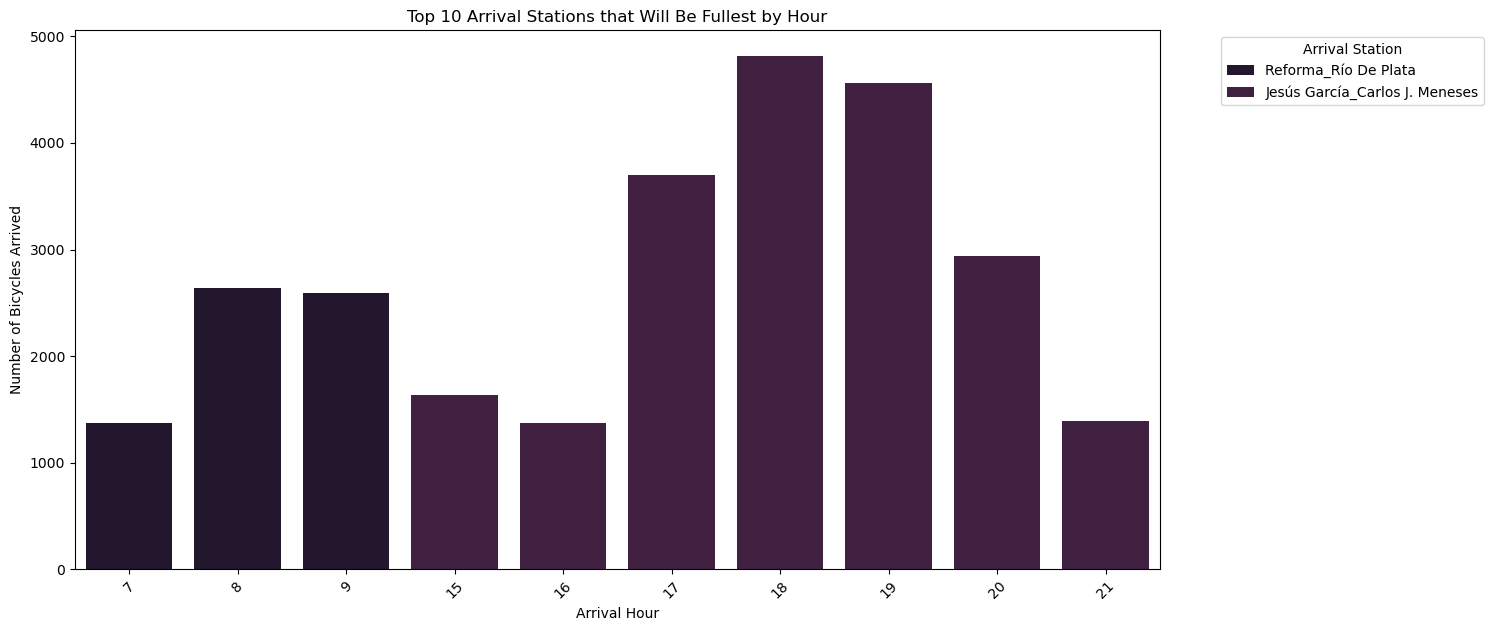

In [36]:
# Definir una paleta de colores
palette = sns.color_palette("rocket", 10)  # Cambia "husl" a otra opción si deseas una paleta diferente

# Gráficas para estaciones que quedarán más llenas por hora
top_arribo_stations = demand_arribo.sort_values('Bicis_Arribo', ascending=False).head(10)

# Unir con los nombres de estaciones para las estaciones de arribo
top_arribo_stations = top_arribo_stations.merge(estaciones_df[['num_cicloe', 'nombre_estacion']], left_on='Ciclo_EstacionArribo', right_on='num_cicloe', how='left')
top_arribo_stations['Station_Name_Arribo'] = top_arribo_stations['nombre_estacion']

plt.figure(figsize=(14, 7))
sns.barplot(x='Hora_Arribo', y='Bicis_Arribo', hue='Station_Name_Arribo', data=top_arribo_stations, palette=palette)
plt.title('Top 10 Arrival Stations that Will Be Fullest by Hour')
plt.xlabel('Arrival Hour')
plt.ylabel('Number of Bicycles Arrived')
plt.xticks(rotation=45)  # Rotar x-ticks para mejor legibilidad
plt.legend(title='Arrival Station', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [57]:
# Get the number of rows using the len() function
num_rows = len(df)
print(f'Total number of rows in the DataFrame: {num_rows}')

Total number of rows in the DataFrame: 1745620
